<center><span style='color:red'>  TODO: Run notebook with python 3.7 and python 2.10 </span>

##### Sensitivity Analysis Results of the effect of Energy Producer Maximum outPut on the Voltage Rise Detected 

Simulation are done in [SensAnalysisP0100](SensAnalysisP0100.ipynb) 
* Prediction block RNN trained in [RNN_Train_StLaurentDeJourdes](RNN_Train_StLaurentDeJourdes.ipynb) 
* RObust RNN To predict $X(k)$ and $Y(k)$  as respectively  $\tilde{X(k)}$ an  $\tilde{Y(k)}$ based on robust Model1 and Model 3 [2021_2022_RNN_Robust_All_Models](2021_2022_RNN_Robust_All_Models.ipynb))
* Prediction Block Future Known [2021_2022_KnownFuture](2021_2022_KnownFuture.ipynb)
* Persistence Model [2021_2022_Persistence](2021_2022_Persistence.ipynb)



Maximum voltage rise $vm_{pu}^{max} = 1.0250 $

---

#### Import Modules 


In [1]:
import pandas as pd
# import pandapower as pp
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pickle, sys, importlib
import joblib
import dill 

##### My own modules and functions

In [2]:
function_folder = 'py_files/' 
# Add function folder to path if it is not already
if function_folder not in sys.path: sys.path.append(function_folder)

import oriFunctions as oriFc
from oriFunctions import network_folder, excel_folder, py_folder, Δt, attr_list

#### Import Simulation results from Simumlation done in [SensAnalysisP0100](SensAnalysisP0100.ipynb) 

In [ ]:
fut_known = joblib.load('pickle_files/simulationResults/SensAnalysisP0100_FutureKnown.pkl')
rnn_pred  = joblib.load('pickle_files/simulationResults/SensAnalysisP0100_RNN.pkl')
rnn_pred_rob1 = joblib.load('pickle_files/simulationResults/SensAnalysisP0100_RNN_Robust_Model1.pkl')
rnn_pred_rob3 = joblib.load('pickle_files/simulationResults/SensAnalysisP0100_RNN_Robust_Model3.pkl')
pers_pred_rob = joblib.load('pickle_files/simulationResults/SensAnalysisP0100_PersRob.pkl')


#### Create daily mask

In [4]:
int_var = fut_known['Sim1']['Power Sgen']
mask = int_var.index.to_timestamp().to_series().between_time('08:10','18:30').index.to_period('10T')

#### Data Reshaping

In [5]:
# Get all the predictor in a list
predictor_list = [fut_known, rnn_pred, rnn_pred_rob1, rnn_pred_rob3, pers_pred_rob]
comb_list ,comb_list_event = [],[]


# Create a list for each variable  (Energy and voltage rise) we're interested in for each predictor considered
fut_known_energyList, fut_known_vRiseList = [], []
rnn_pred_energyList, rnn_pred_vRiseList = [], []
rnn_pred_rob1_energyList, rnn_pred_rob1_vRiseList = [], []
rnn_pred_rob3_energyList, rnn_pred_rob3_vRiseList = [], []
pers_pred_rob_energyList, pers_pred_rob_vRiseList = [], []


# Collect all the same type of variable in a list
predictor_energyList = [fut_known_energyList, rnn_pred_energyList, rnn_pred_rob1_energyList, rnn_pred_rob3_energyList, pers_pred_rob_energyList]
predictor_vRiseList = [fut_known_vRiseList, rnn_pred_vRiseList, rnn_pred_rob1_vRiseList, rnn_pred_rob3_vRiseList, pers_pred_rob_vRiseList]




for cur_sim in list(fut_known.keys())[1:]:  # For each simulation ['Sim1', 'Sim2' .... , 'Sim20']
   
    int_var_events = [] # " Intermediate variables"
    int_var = []
    
    # Get the power of P0100 when no control is applied for each instant for the current simulation
    var_no_control_curSim =  fut_known[cur_sim]['Power Sgen']['No_Control'].loc[mask]
    
    for cur_indx, cur_predictor in enumerate(predictor_list):  # For each model to consider
        
        # Extract Power variables for the current predictor 
        var_no_control, var_curPredictor = cur_predictor[cur_sim]['Power Sgen'].loc[mask].sum()*Δt 
        
        # Save variables
        predictor_energyList[cur_indx].append([var_no_control, var_curPredictor, var_curPredictor*100/var_no_control])
                
        # Save The total Energy of the current predictor
        int_var.append(var_curPredictor)
        
        # Substract the no conrolled power of P0100 from the controlled  with the current predictor to get positive values 
        # When their are different
        var2 = var_no_control_curSim - cur_predictor[cur_sim]['Power Sgen'].loc[mask].iloc[:,-1]
        
        # Save the total number of instants where the power with no control > to that of the current predictor
        int_var_events.append((var2>0).sum())

        
        if cur_indx != 0 :
            var  = cur_predictor[cur_sim]['maxV_rise_df'].loc[mask]
            vRise_thresholded = var[var>1.025]
            predictor_vRiseList[cur_indx].append(vRise_thresholded)

    # Add element to list
    comb_list_event.append(int_var_events) 
    comb_list.append([var_no_control-elm for elm in int_var])

In [6]:
predictor_energyList[0][-1],predictor_energyList[1][-1], predictor_energyList[2][-1], predictor_energyList[3][-1], predictor_energyList[4][-1]

([5060.71, 4704.867870432496, 92.9685334751941],
 [5060.71, 4442.248634046482, 87.77915814276025],
 [5060.71, 4755.334792982472, 93.96576355852187],
 [5060.71, 4734.939122988595, 93.56274362665702],
 [5060.71, 4724.882630191528, 93.3640265929391])

#### Plot Variation of the yearly curtailed energy function of  P0100 output

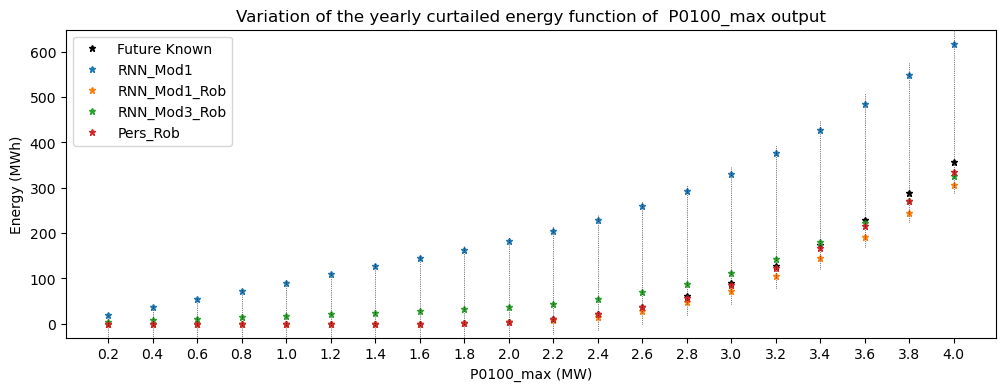

In [7]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']
P0100_max = 4
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)
# p0100_maxRange = np.round(P0100_max_range[1:], decimals=2) # Create range for each value of P0100_max

fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list).shape[1]): 
    axx.plot(np.array(comb_list)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks(range(20), labels=np.round(P0100_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Energy (MWh)', xlabel = 'P0100_max (MW)')
axx.set_title("Variation of the yearly curtailed energy function of  P0100_max output")


for rows in range(20):
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.5, color='k', ls=':')

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
plt.legend(model_names)

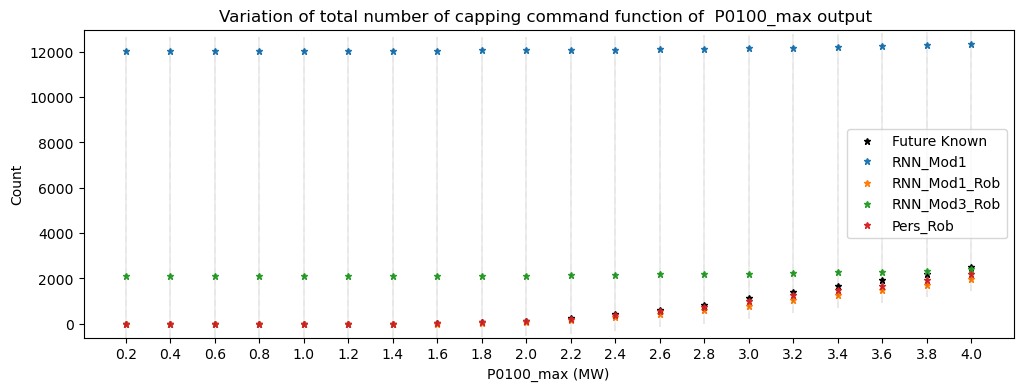

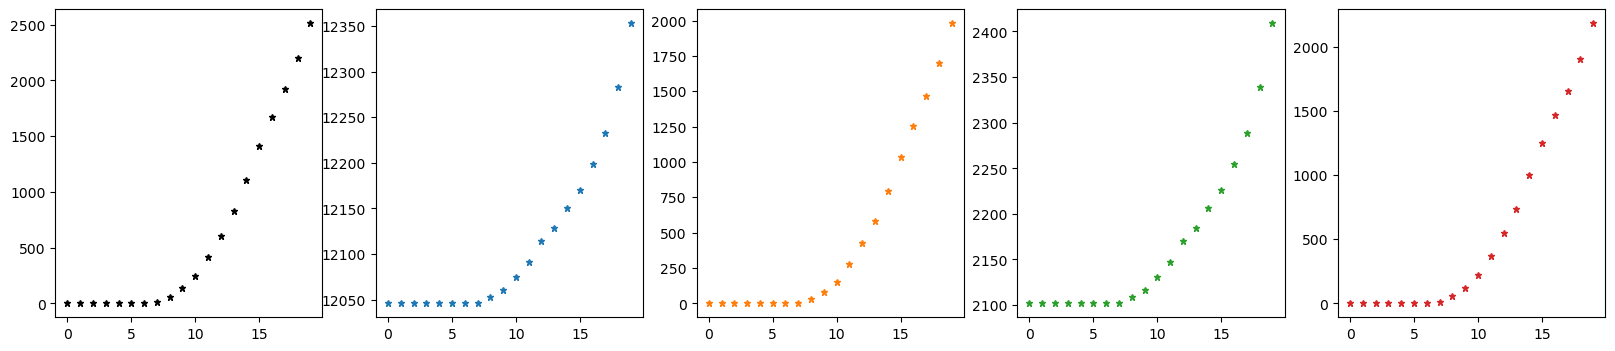

In [8]:
color_list = ['k', 'tab:blue', 'tab:orange','tab:green', 'tab:red']
P0100_max = 4
P0100_max_range = np.arange(0, P0100_max+0.1 ,0.2)
# p0100_maxRange = np.round(P0100_max_range[1:], decimals=2) # Create range for each value of P0100_max

fig, axx = plt.subplots(1, figsize=(12,4))
for elm in range(np.array(comb_list_event).shape[1]): 
    axx.plot(np.array(comb_list_event)[:,elm].round(decimals=3), ls='', marker='*', markersize=5,color=color_list[elm])
    
plt.xticks(range(20), labels=np.round(P0100_max_range[1:], decimals=2), rotation=0);
var = np.array(comb_list_event).round(decimals=3)
axx.get_facecolor
axx.set(ylabel = 'Count', xlabel = 'P0100_max (MW)')
axx.set_title("Variation of total number of capping command function of  P0100_max output ")

for rows in range(20):
    axx.axvline(x=axx.get_xticks()[rows], 
                ymin= var[rows].min()/(axx.get_ylim()[1]), 
                ymax=0.046+var[rows].max()/axx.get_ylim()[1], lw=0.3, color='k', ls=':')

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
plt.legend(model_names)



fig, axx = plt.subplots(1,5, figsize=(20,4))
for elm, cur_ax in zip(range(np.array(comb_list_event).shape[1]), axx.flatten()): 
    cur_ax.plot(np.array(comb_list_event)[:,elm].round(decimals=2), ls='', marker='*', markersize=5,color=color_list[elm])

model_names = ['Future Known','RNN_Mod1','RNN_Mod1_Rob','RNN_Mod3_Rob', 'Pers_Rob']
# fig.legend(model_names, bbox_to_anchor=(0.22,0.8))

##### How can one explain the behavior of the RNN_Mod3_Rob
It is important to notice that the Robust RNN model 3 which predicts voltage rise values has been trained with data provided by P0100_max = 4MWh. We assume that the parameters learn in this specific training case do not generalize for lower values of P0100_max which could explain why the total number of capping command is higher than that of the other controller

<div class = 'alert alert-block alert-info' >
<b> TODO:</b>
    Train a new RNN for each P0100_max
</div>

#### Reshape data into dataframe to do a categorical Plot

In [9]:
df2usev= pd.DataFrame(columns=['V_rise','Model', 'Power']) # Create empty dataframe with following collumns
p0100_maxRange = np.round(P0100_max_range[1:], decimals=2)

for cur_predictor_ind in range(1,5): # For the current model_index
    for p_max_ind in range(20): # For each value of P0100_max
        
        # Create a dataframe of voltage rise
        df = pd.DataFrame(predictor_vRiseList[cur_predictor_ind][p_max_ind].dropna().values, columns=['V_rise'])
        
        # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
        df[['Model', 'Power']] = model_names[cur_predictor_ind], p0100_maxRange[p_max_ind]
        
        df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe

        
        
# Add values for the No control model to the previous created dataframe        
for cur_index, cur_sim in enumerate(list(fut_known.keys())[1:]): 
    # Extract values of voltage rise when no control and apply mask to.
    var = fut_known[cur_sim]['maxV_rise_pf_df'].loc[mask]
    
    # Create a dataframe using the thresholded values of the precedend var
    df = pd.DataFrame(var[var>1.025].dropna().values, columns=['V_rise'])
    
    # Add to the previously created dataframe columns ['Model', 'Power'] based on the model name and P0100's power
    df[['Model', 'Power']] = 'No_Control', p0100_maxRange[cur_index]
    
    df2usev = pd.concat([df2usev, df]) # Concatanate created dataframe with the exsisting dataframe
    

#### Plot Categorical data

<span style='color:red'> Might be interesting to explain boxplots ([See figure](https://www.researchgate.net/publication/340996565/figure/fig3/AS:962186885210119@1606414638167/Box-plot-and-probability-density-function-of-a-normal-distribution.png) ) before showing off this pictures</span>




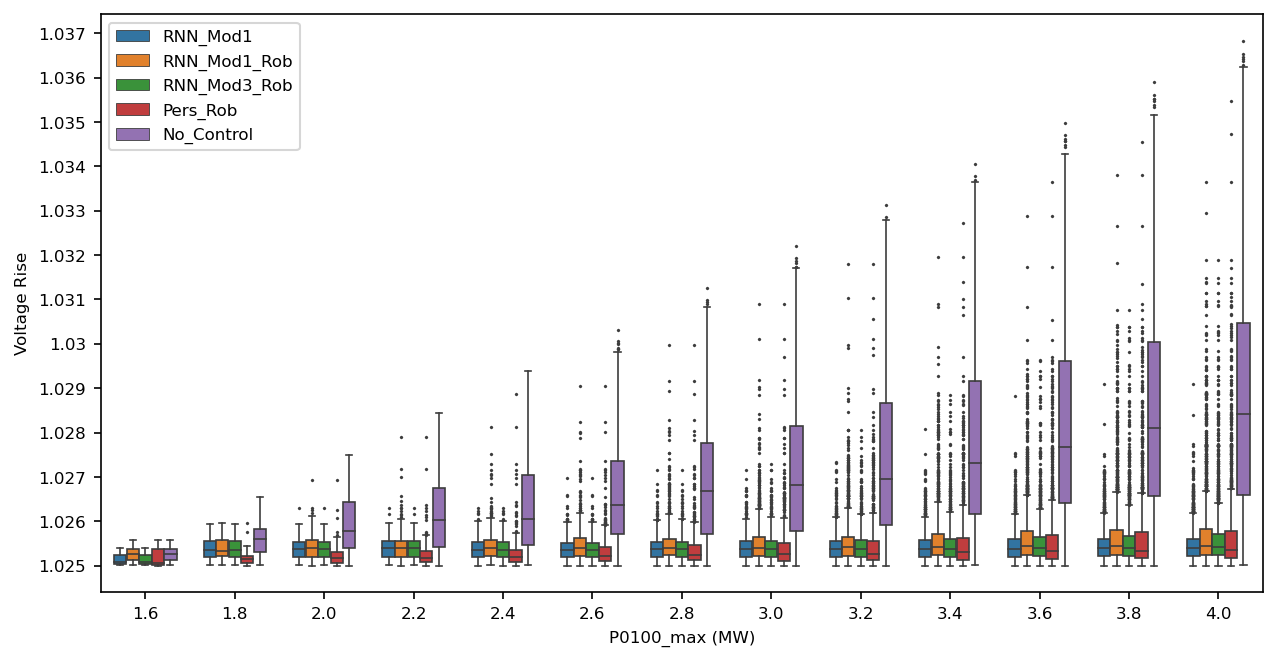

In [10]:
# filtered= df2usev[(df2usev["Model"] == 'RNN_Mod1') | (df2usev["Model"] == 'No_Control')]
flprop = dict(marker='x',)
fig, axx = plt.subplots(figsize=(10,5), dpi=150)
sbn.boxplot(x='Power', y='V_rise', data=df2usev, hue='Model', width=0.7, fliersize=1,linewidth=0.8, 
            flierprops=flprop, 
            
           )
lblsize = 8 
axx.set_xlabel('P0100_max (MW)', size=lblsize )
axx.set_ylabel('Voltage Rise', size=lblsize )
axx.set_xticklabels(p0100_maxRange[7:],size=lblsize )
axx.set_yticks(ticks=np.arange(1.025,1.037,0.001),
               labels=np.round(np.arange(1.025,1.037,0.001), decimals=3), size=lblsize)
axx.legend(fontsize=lblsize)

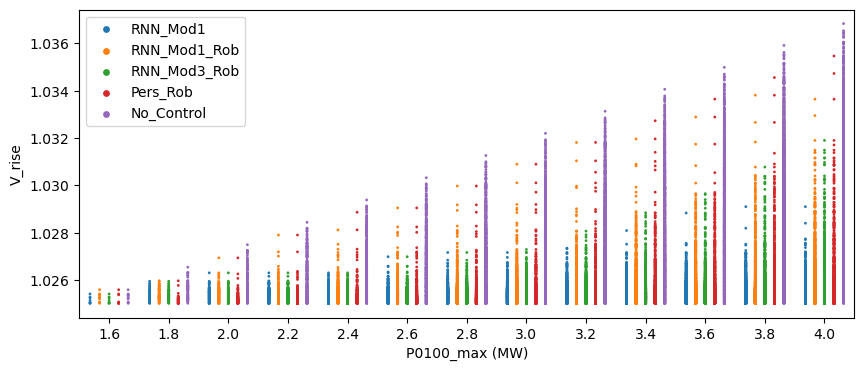

In [21]:
fig, axx = plt.subplots(figsize=(10,4), dpi=100)
sbn.stripplot(x='Power', y='V_rise', data=df2usev, hue='Model',ax=axx, size=2,  dodge=True,jitter=False)
axx.set( xlabel = 'P0100_max (MW)')
axx.legend(markerscale=0.5)

#### Get the Total number of event where the voltage rise is above defined threshold for each model

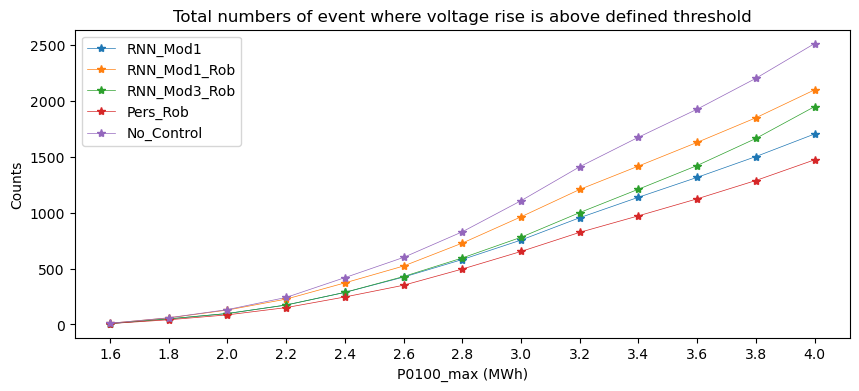

In [18]:
aa = pd.concat([df2usev.groupby(by=['Model', 'Power']).count().T[mod_name] for mod_name in df2usev.Model.unique()])
aa.index = df2usev.Model.unique()

fig, axx = plt.subplots(figsize=(10,4), dpi=100)
aa.T.plot(marker='*', lw=0.5, ax= axx)
plt.xticks(np.arange(1.6,4.1,0.2))
axx.set(xlabel='P0100_max (MWh)', ylabel='Counts', title='Total numbers of event where voltage rise is above defined threshold');